In [1]:
#os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay

#Deep learnings tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#warnings
import warnings
warnings.filterwarnings('ignore')

2024-02-04 16:18:17.698554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 16:18:17.698606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 16:18:17.699979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Prepararion

In [2]:
train_data = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_data = '/kaggle/input/intel-image-classification/seg_test/seg_test'

filepath= []
label =[]

folds = os.listdir(train_data)

for fold in folds:
    f_path = os.path.join(train_data , fold)
    imgs = os.listdir(f_path)
    
    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
train_df = pd.concat([fseries , lseries] , axis = 1)

In [3]:
folds = os.listdir(test_data)

for fold in folds:
    f_path = os.path.join(test_data , fold)
    imgs = os.listdir(f_path)
    
    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
ts_df = pd.concat([fseries , lseries] , axis = 1)

In [4]:
train_df

,filepaths,labels
0,/kaggle/input/intel-image-classification/seg_t...,mountain
1,/kaggle/input/intel-image-classification/seg_t...,mountain
2,/kaggle/input/intel-image-classification/seg_t...,mountain
3,/kaggle/input/intel-image-classification/seg_t...,mountain
4,/kaggle/input/intel-image-classification/seg_t...,mountain
...,...,...
14029,/kaggle/input/intel-image-classification/seg_t...,glacier
14030,/kaggle/input/intel-image-classification/seg_t...,glacier
14031,/kaggle/input/intel-image-classification/seg_t...,glacier
14032,/kaggle/input/intel-image-classification/seg_t...,glacier


In [5]:
ts_df

,filepaths,labels
0,/kaggle/input/intel-image-classification/seg_t...,mountain
1,/kaggle/input/intel-image-classification/seg_t...,mountain
2,/kaggle/input/intel-image-classification/seg_t...,mountain
3,/kaggle/input/intel-image-classification/seg_t...,mountain
4,/kaggle/input/intel-image-classification/seg_t...,mountain
...,...,...
17029,/kaggle/input/intel-image-classification/seg_t...,glacier
17030,/kaggle/input/intel-image-classification/seg_t...,glacier
17031,/kaggle/input/intel-image-classification/seg_t...,glacier
17032,/kaggle/input/intel-image-classification/seg_t...,glacier


## Data Splitting

In [6]:
valid , test = train_test_split(ts_df , test_size= 0.5 , shuffle = True , random_state = 42)

In [7]:
print(f"Shape of Validation set is: {valid.shape}")
print(f"Shape of Test set is: {test.shape}")

Shape of Validation set is: (8517, 2)
Shape of Test set is: (8517, 2)


## Image Generator

In [8]:
img_size = (150 ,150)
batch_size = 32

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'labels' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 14034 validated image filenames belonging to 6 classes.
Found 8517 validated image filenames belonging to 6 classes.
Found 8517 validated image filenames belonging to 6 classes.


## Show Sample from Train Data

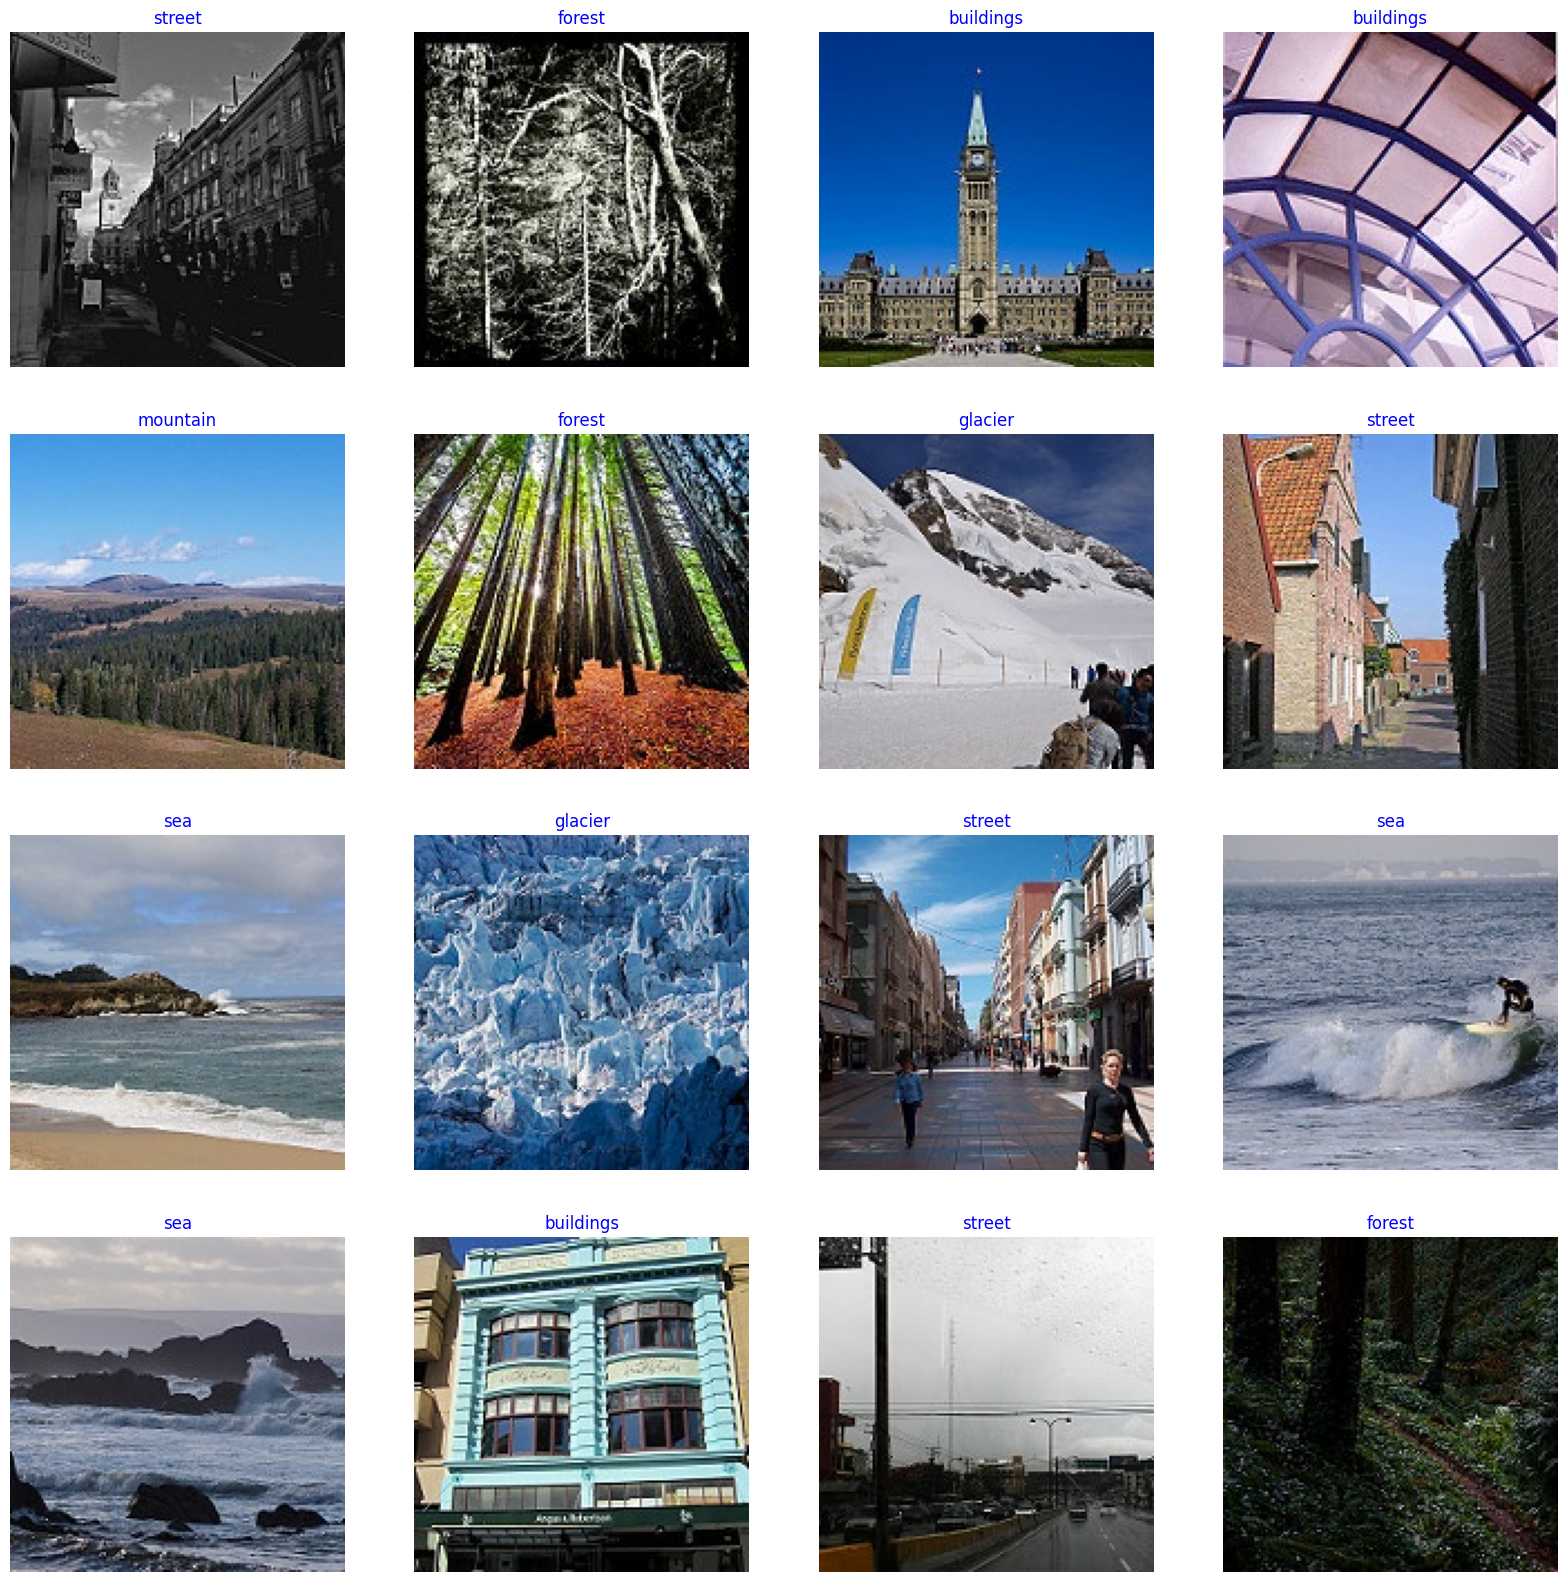

In [9]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(train_gen)

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

## Model Structure

In [10]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 6)                 1542      
                                                         

## Training

In [11]:
epochs = 10

history = model.fit(x = train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False )

Epoch 1/10


2024-02-04 16:40:54.654002: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707064861.472032     991 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 [==============================] - 233s 445ms/step - loss: 0.3355 - accuracy: 0.8814 - val_loss: 0.1279 - val_accuracy: 0.9580
Epoch 2/10
439/439 [==============================] - 74s 169ms/step - loss: 0.1602 - accuracy: 0.9416 - val_loss: 0.1169 - val_accuracy: 0.9548
Epoch 3/10
439/439 [==============================] - 73s 167ms/step - loss: 0.1015 - accuracy: 0.9644 - val_loss: 0.0727 - val_accuracy: 0.9745
Epoch 4/10
439/439 [==============================] - 73s 167ms/step - loss: 0.0704 - accuracy: 0.9756 - val_loss: 0.0563 - val_accuracy: 0.9840
Epoch 5/10
439/439 [==============================] - 73s 166ms/step - loss: 0.0582 - accuracy: 0.9803 - val_loss: 0.0589 - val_accuracy: 0.9861
Epoch 6/10
439/439 [==============================] - 74s 168ms/step - loss: 0.0440 - accuracy: 0.9850 - val_loss: 0.0537 - val_accuracy: 0.9857
Epoch 7/10
439/439 [==============================] - 74s 169ms/step - loss: 0.0379 - accuracy: 0.9878 - val_loss: 0.0629 - val_accuracy: 0.

## Model Performance

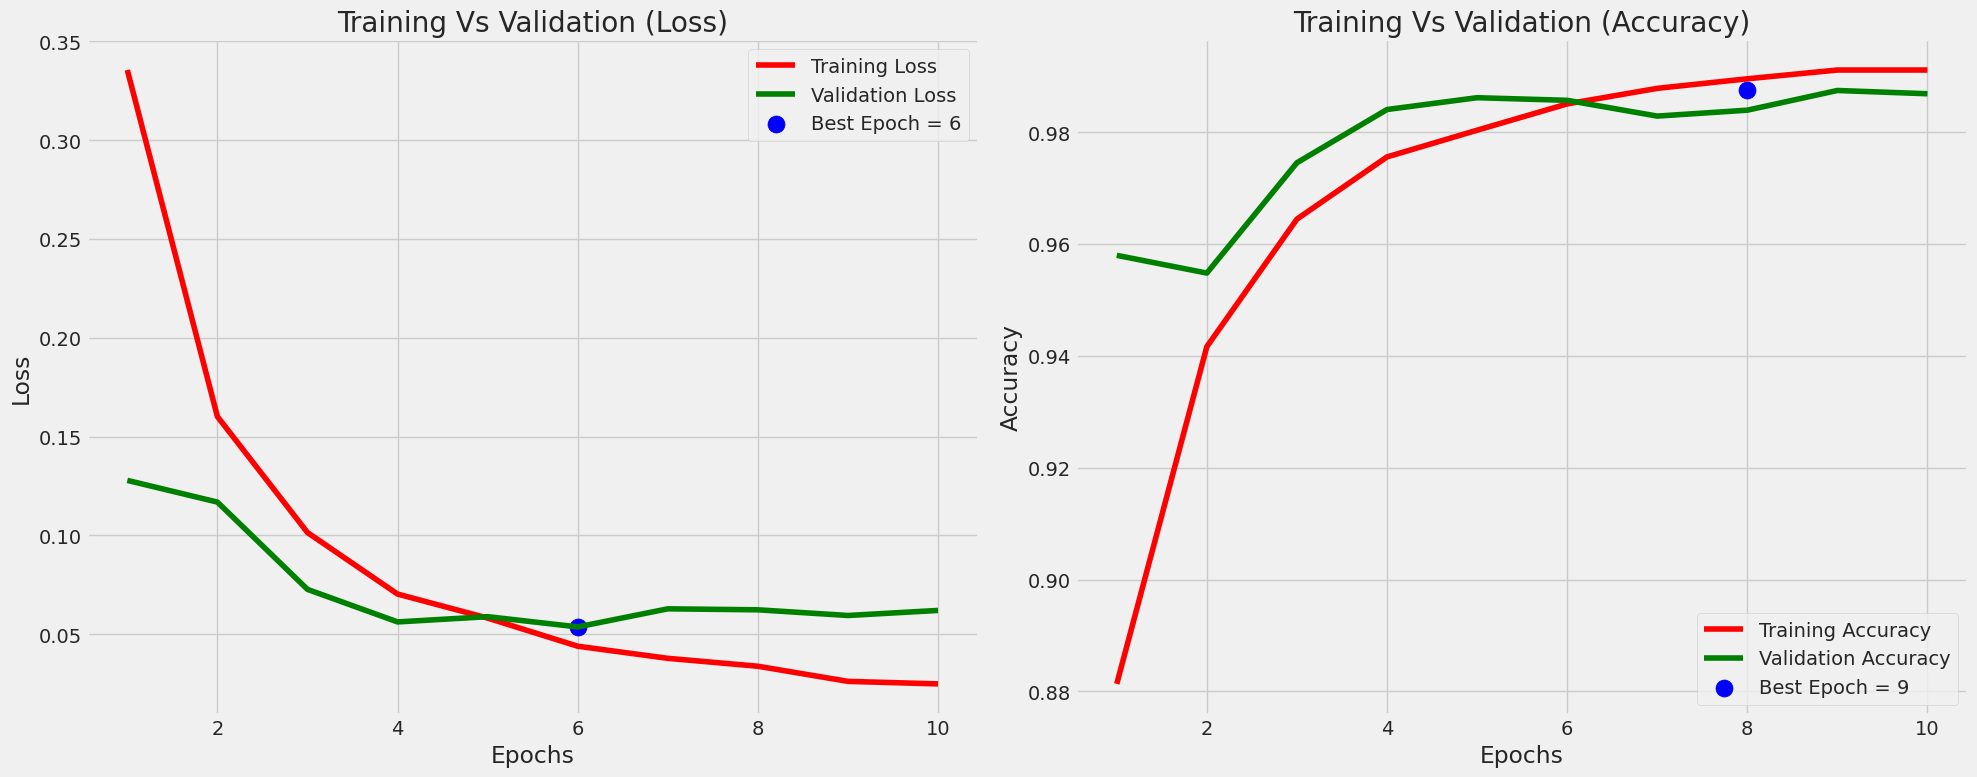

In [18]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

## Model Evaluation

In [19]:
train_score = model.evaluate(train_gen , steps = 32 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

32/32 [==============================] - 4s 128ms/step - loss: 0.0742 - accuracy: 0.9883
Train Loss:  0.004187403246760368
Train Accuracy:  0.9990234375
--------------------
Validation Loss:  0.11427323520183563
Validation Accuracy:  0.98046875
--------------------
Test Loss:  0.07422740012407303
Test Accuracy:  0.98828125


## Model Prediction

### Confusion Matrix

In [20]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)

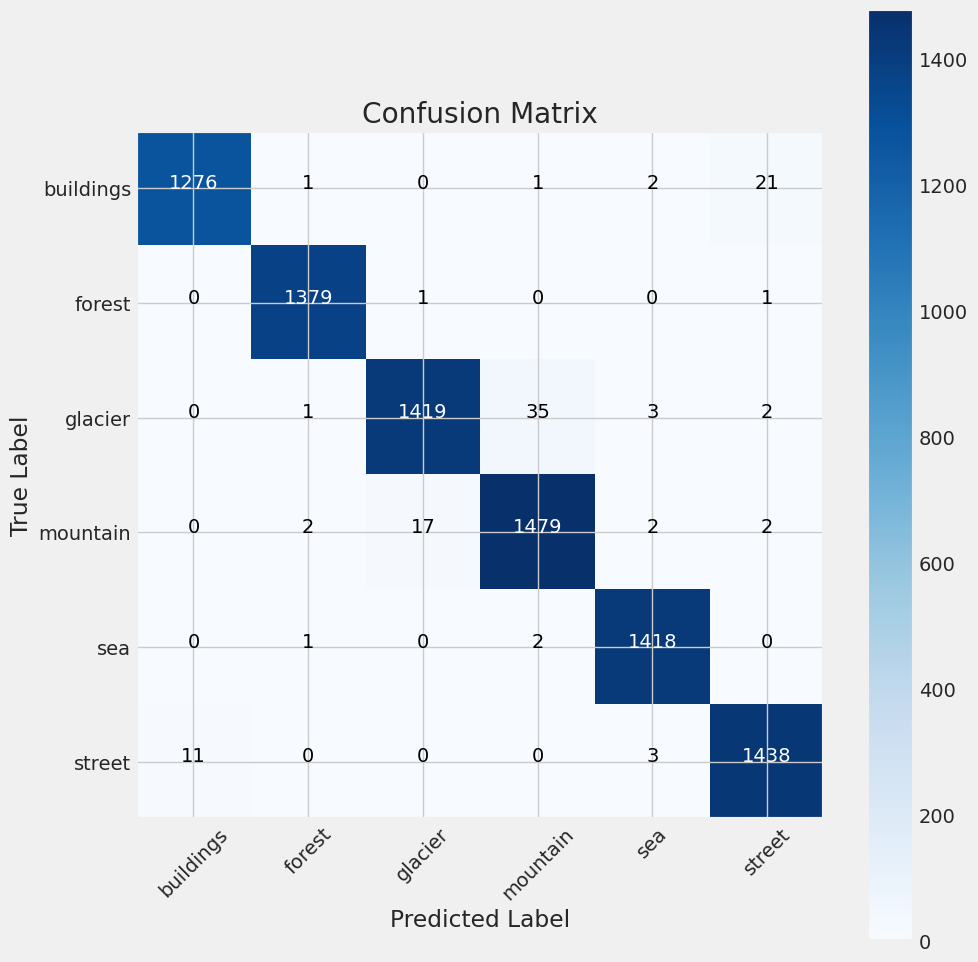

In [21]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

### Classification report

In [22]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

   buildings       0.99      0.98      0.99      1301
      forest       1.00      1.00      1.00      1381
     glacier       0.99      0.97      0.98      1460
    mountain       0.97      0.98      0.98      1502
         sea       0.99      1.00      1.00      1421
      street       0.98      0.99      0.99      1452

    accuracy                           0.99      8517
   macro avg       0.99      0.99      0.99      8517
weighted avg       0.99      0.99      0.99      8517

